In [132]:
# import libraries
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg # For displaying images
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Rescaling
import tensorflow.keras.preprocessing  as kp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras.models import model_from_json
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import keras
from tensorflow.keras.backend import sum, round, clip, epsilon
import os

ModuleNotFoundError: No module named 'tensorflow.data.Dataset'

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
PATH = "Data/"

train_dir = os.path.join(PATH, 'Training')
validation_dir = os.path.join(PATH, 'Validation')

BATCH_SIZE = 48
IMG_SIZE = (250, 250)
IMG_SHAPE = IMG_SIZE + (3,)

In [4]:
train_dir

'Data/Training'

In [5]:
train_datagen = ImageDataGenerator( # Data Augumentation for test data
                rescale=1./255,
                rotation_range=30,
                shear_range=0.3,
                zoom_range=0.3
                )

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_gen=train_datagen.flow_from_directory(train_dir,
                                            target_size=IMG_SIZE,
                                            batch_size=BATCH_SIZE,
                                            class_mode='binary')

Found 47009 images belonging to 2 classes.


In [7]:
valid_gen=test_datagen.flow_from_directory(validation_dir,
                                           target_size=(250,250),
                                           batch_size=48,
                                           class_mode='binary',
                                          shuffle=False)

Found 11649 images belonging to 2 classes.


## Define functions

In [8]:
def plot_loss(history):
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)

In [9]:
def plot_acc(history):
    plt.figure(figsize=[8,6])
    plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training accuracy', 'Validation accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

In [10]:
from sklearn.metrics import confusion_matrix

def recall(y_true, y_pred):
    y_true = tf.ones_like(y_true) 
    true_positives = sum(round(clip(y_true * y_pred, 0, 1)))
    all_positives = sum(round(clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = tf.ones_like(y_true) 
    true_positives = sum(round(clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = sum(round(clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + epsilon())
    return precision

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+epsilon()))


## MobileNet v2

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [29]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_mn = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [23]:
base_model_mn.summary()

(250, 250, 3)

### baseline

In [30]:
base_model_mn.trainable = False

In [65]:
output_mn = base_model_mn.output
output_mn = Flatten()(output_mn)
predict_mn = Dense(1, activation="sigmoid")(output_mn)
base_mn = Model(base_model_mn.input, predict_mn)


In [66]:
base_learning_rate = 0.0001
base_mn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [58]:
base_mn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 125, 125, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 125, 125, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [68]:
epochs=5
history_mn_base = base_mn.fit(train_gen,
                    epochs=epochs,
                    validation_data=valid_gen)

Epoch 1/5
980/980 [==============================] - 733s 748ms/step - loss: 0.2897 - accuracy: 0.8823 - val_loss: 0.2663 - val_accuracy: 0.8923
Epoch 2/5
980/980 [==============================] - 512s 522ms/step - loss: 0.2475 - accuracy: 0.9056 - val_loss: 0.2319 - val_accuracy: 0.9112
Epoch 3/5
980/980 [==============================] - 511s 521ms/step - loss: 0.2291 - accuracy: 0.9134 - val_loss: 0.2615 - val_accuracy: 0.8983
Epoch 4/5
980/980 [==============================] - 584s 596ms/step - loss: 0.2242 - accuracy: 0.9156 - val_loss: 0.2042 - val_accuracy: 0.9220
Epoch 5/5
980/980 [==============================] - 517s 527ms/step - loss: 0.2205 - accuracy: 0.9175 - val_loss: 0.2432 - val_accuracy: 0.9063


In [21]:
history_mn_base.save("D:/桌面/MSiA/SPRING 2022/432 Deep Learning/Project/saved_model/mobilenet_0505_9004")

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 256, 256, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 125, 125, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

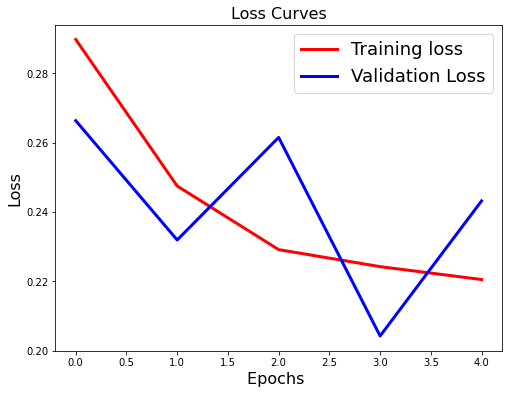

In [72]:
plot_loss(history_mn_base)

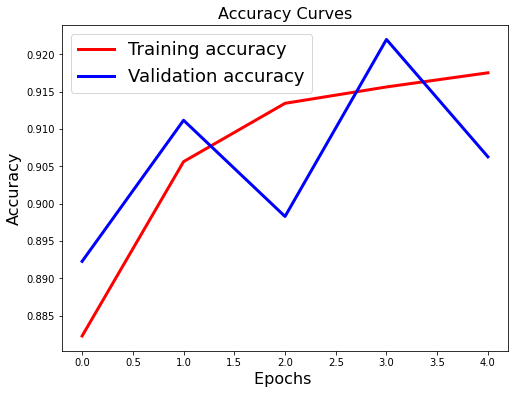

In [73]:
plot_acc(history_mn_base)

## DenseNet 169

In [75]:
from tensorflow.keras.applications import densenet

In [76]:
preprocess_input = densenet.preprocess_input

In [77]:
rescale = Rescaling(1./127.5, offset=-1)

In [79]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_dn = densenet.DenseNet169(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [81]:
base_model_dn.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 256, 256, 3)  0          ['input_9[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 125, 125, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                       

### baseline

In [82]:
base_model_dn.trainable = False

In [86]:
output_dn = base_model_dn.output
output_dn = Flatten()(output_dn)
predict_dn = Dense(1, activation="sigmoid")(output_dn)
base_dn = Model(base_model_dn.input, predict_dn)


In [88]:
base_learning_rate = 0.0001
base_dn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [89]:
base_dn.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 256, 256, 3)  0          ['input_9[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 125, 125, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

In [90]:
epochs=5
history_dn_base = base_dn.fit(train_gen,
                    epochs=epochs,
                    validation_data=valid_gen)

Epoch 1/5
980/980 [==============================] - 540s 543ms/step - loss: 0.2401 - accuracy: 0.9054 - val_loss: 0.1725 - val_accuracy: 0.9388
Epoch 2/5
980/980 [==============================] - 528s 538ms/step - loss: 0.1871 - accuracy: 0.9315 - val_loss: 0.1294 - val_accuracy: 0.9521
Epoch 3/5
980/980 [==============================] - 529s 540ms/step - loss: 0.1788 - accuracy: 0.9349 - val_loss: 0.1462 - val_accuracy: 0.9495
Epoch 4/5
980/980 [==============================] - 531s 542ms/step - loss: 0.1697 - accuracy: 0.9387 - val_loss: 0.1419 - val_accuracy: 0.9503
Epoch 5/5
980/980 [==============================] - 532s 542ms/step - loss: 0.1656 - accuracy: 0.9396 - val_loss: 0.1242 - val_accuracy: 0.9566


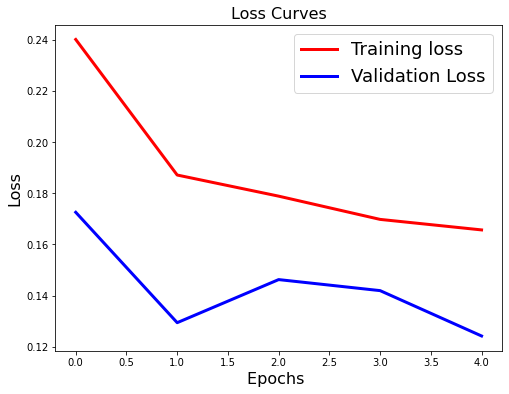

In [91]:
plot_loss(history_dn_base)

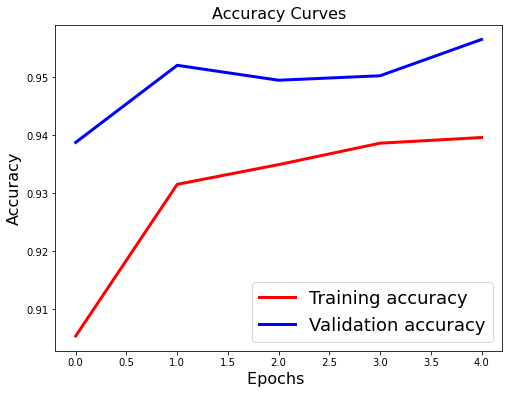

In [92]:
plot_acc(history_dn_base)

In [94]:
#save model to disk
model_json = base_dn.to_json()
with open('dn169_model.json', 'w') as json_file:
    json_file.write(model_json)
base_dn.save_weights('dn169_model.h5') 

## VGG 16

In [12]:
from tensorflow.keras.applications import VGG16

In [13]:
base_model_vgg=VGG16(include_top=False, pooling='avg', weights='imagenet',
input_shape= IMG_SHAPE)

2022-05-28 13:19:15.517090: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-28 13:19:18.523251: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-28 13:19:18.523308: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7390 MB memory:  -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:09:00.0, compute capability: 6.1


In [14]:
base_model_vgg.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

### baseline

In [15]:
base_model_vgg.trainable = False

In [16]:
output_vgg = base_model_vgg.output
output_vgg = Flatten()(output_vgg)
predict_vgg = Dense(1, activation="sigmoid")(output_vgg)
base_vgg = Model(base_model_vgg.input, predict_vgg)

In [17]:
base_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [18]:
# adam = Adam()
lr = 0.0001
base_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [19]:
epochs=5
history_vgg_base = base_vgg.fit(train_gen,
                    epochs=epochs,
                    validation_data=valid_gen)

Epoch 1/5


2022-05-28 13:19:32.245154: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-05-28 13:19:33.715742: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-28 13:19:33.793174: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-28 13:19:34.150347: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are runn

  8/980 [..............................] - ETA: 7:41 - loss: 0.8169 - accuracy: 0.4766

KeyboardInterrupt: 

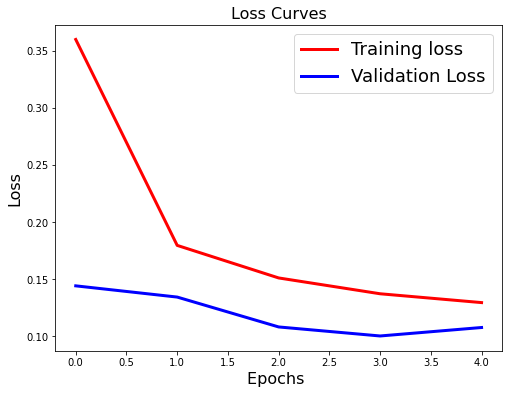

In [114]:
plot_loss(history_vgg_base)

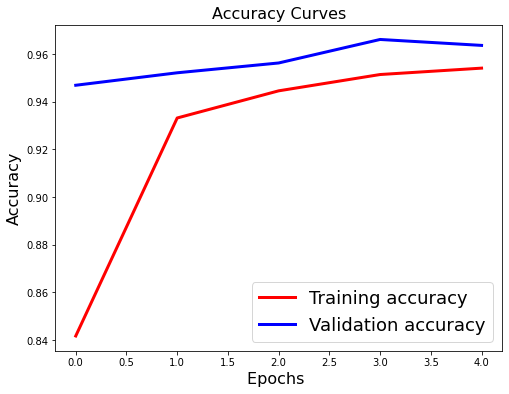

In [116]:
plot_acc(history_vgg_base)

### Fine-tuning VGG 16

In [20]:
base_model_vgg_tune=VGG16(include_top=False, pooling='avg', weights='imagenet',
input_shape= IMG_SHAPE)

In [21]:
# Unfreeze the base model
base_model_vgg_tune.trainable = True

In [22]:
output_vgg_tune = base_model_vgg_tune.output
#output_vgg_tune = Flatten()(output_vgg_tune)
output_vgg_tune = Dense(16, activation='relu')(output_vgg_tune)
output_vgg_tune = BatchNormalization()(output_vgg_tune)
predict_vgg_tune = Dense(1, activation="sigmoid")(output_vgg_tune)
base_vgg_tune = Model(base_model_vgg_tune.input, predict_vgg_tune)

In [23]:
base_vgg_tune.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0   

In [40]:
# adam = Adam()
lr = 0.00001
base_vgg_tune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy", recall, precision, f1_score])

In [25]:
epochs=10
history_vgg_tune = base_vgg_tune.fit(train_gen,
                    epochs=epochs,
                    validation_data=valid_gen)

Epoch 1/10


2022-05-28 13:19:55.459383: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-28 13:19:56.261461: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-28 13:19:56.689018: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-28 13:19:56.902231: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

980/980 [==============================] - 696s 706ms/step - loss: 0.1932 - accuracy: 0.9335 - recall: 0.5115 - precision: 1.0000 - f1_score: 0.6752 - val_loss: 0.1157 - val_accuracy: 0.9613 - val_recall: 0.5148 - val_precision: 0.9753 - val_f1_score: 0.5447
Epoch 2/10
980/980 [==============================] - 692s 706ms/step - loss: 0.1359 - accuracy: 0.9588 - recall: 0.5067 - precision: 1.0000 - f1_score: 0.6705 - val_loss: 0.1734 - val_accuracy: 0.9436 - val_recall: 0.4449 - val_precision: 0.5556 - val_f1_score: 0.4724
Epoch 3/10
980/980 [==============================] - 693s 706ms/step - loss: 0.1229 - accuracy: 0.9642 - recall: 0.5059 - precision: 1.0000 - f1_score: 0.6698 - val_loss: 0.0878 - val_accuracy: 0.9738 - val_recall: 0.4967 - val_precision: 0.8560 - val_f1_score: 0.5153
Epoch 4/10
980/980 [==============================] - 693s 706ms/step - loss: 0.1149 - accuracy: 0.9664 - recall: 0.5054 - precision: 1.0000 - f1_score: 0.6690 - val_loss: 0.0987 - val_accuracy: 0.9737

In [41]:
#save model to disk
model_json = base_vgg_tune.to_json()
with open('base_model_vgg_tune.json', 'w') as json_file:
    json_file.write(model_json)
base_vgg_tune.save_weights('base_model_vgg_tune.h5') 

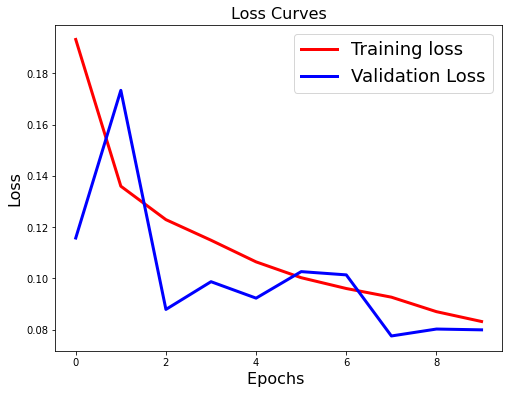

In [32]:
plot_loss(history_vgg_tune)

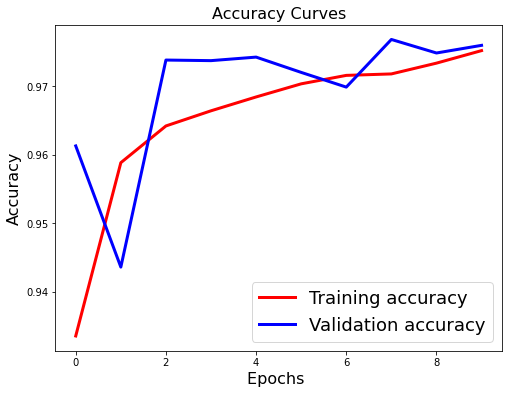

In [33]:
plot_acc(history_vgg_tune)

# VGG 16 Evaluation

In [42]:
#testing - accuracy
scores = base_vgg_tune.evaluate(valid_gen, batch_size=BATCH_SIZE, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

243/243 [==============================] - 54s 220ms/step - loss: 0.0799 - accuracy: 0.9760 - recall: 0.4829 - precision: 0.6626 - f1_score: 0.4970

Test result: 97.596 loss: 0.080


In [43]:
# y predictions, class
y_pred = base_vgg_tune.predict(valid_gen)
y_pred_class = np.where(y_pred > 0.5, 1, 0)


In [46]:
print(classification_report(valid_gen.classes, y_pred_class))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5841
           1       0.99      0.96      0.98      5808

    accuracy                           0.98     11649
   macro avg       0.98      0.98      0.98     11649
weighted avg       0.98      0.98      0.98     11649



[[5796   45]
 [ 235 5573]]


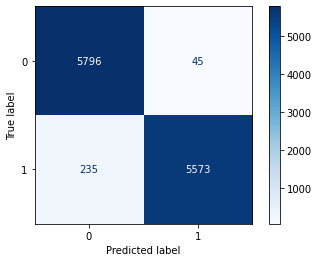

In [50]:
print(confusion_matrix(valid_gen.classes, y_pred_class))
cm = confusion_matrix(valid_gen.classes, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm) #, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [66]:
# misclassification
y_pred_ls = [int(ls) for ls in y_pred_class]
errors = (y_pred_ls - valid_gen.classes != 0)
errors_indices = [i for i, x in enumerate(errors) if x == True]

array([False, False, False, ..., False, False, False])

In [164]:
len(errors_indices)/len(errors)

0.024036397974075027

In [140]:
valid_gen_nobatch=test_datagen.flow_from_directory(validation_dir,
                                           target_size=(250,250),
                                           batch_size=1,
                                           class_mode='binary',
                                          shuffle=False)

Found 11649 images belonging to 2 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

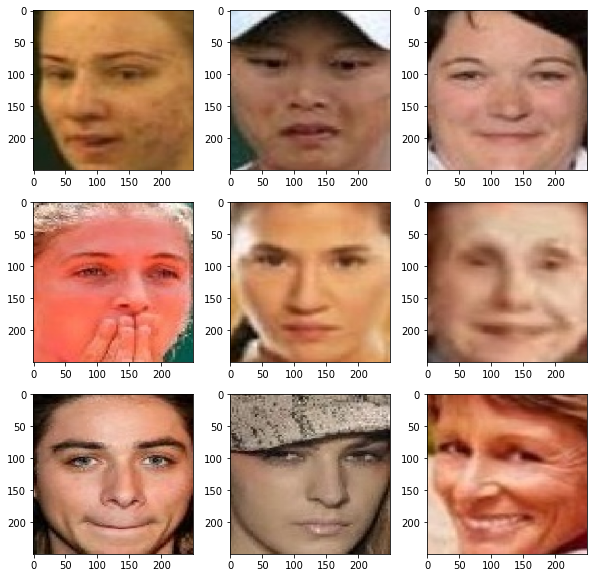

In [187]:
# female misclassified as males
plt.figure(figsize=(10, 10))
ind = 0
for i in errors_indices[:9]:
    x= valid_gen_nobatch.__getitem__(i)
    ax = plt.subplot(3, 3, ind + 1)        
    image = x[0][0]
    plt.imshow(image)
    ind += 1

valid_gen_nobatch.classes[errors_indices[:9]]     


array([1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

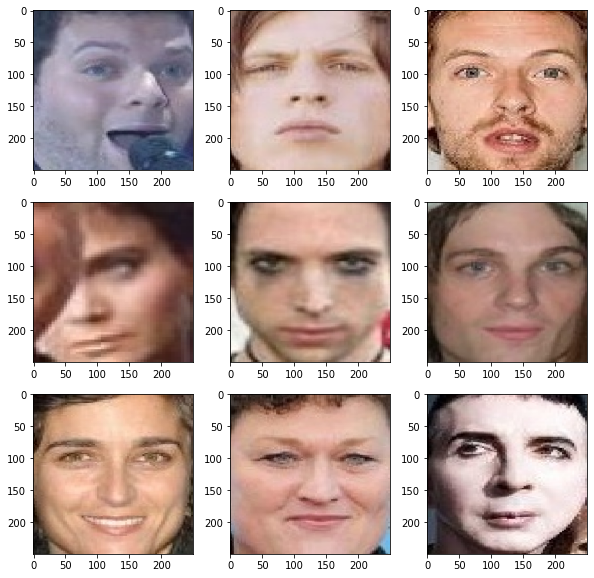

In [225]:
# males misclassified as females
misclass_index = [208,223, 232, 233, 234, 238, 242, 258, 268]

plt.figure(figsize=(10, 10))
ind = 0
for i in list(errors_indices[i] for i in misclass_index):
    x= valid_gen_nobatch.__getitem__(i)
    ax = plt.subplot(3, 3, ind + 1)        
    image = x[0][0]
    plt.imshow(image)
    ind += 1

valid_gen_nobatch.classes[[errors_indices[i] for i in  misclass_index]]

# []

In [242]:
# Feature maps
# summarize feature map shapes
for i in range(len(base_vgg_tune.layers)):
    layer = base_vgg_tune.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)


1 block1_conv1 (None, 250, 250, 64)
2 block1_conv2 (None, 250, 250, 64)
4 block2_conv1 (None, 125, 125, 128)
5 block2_conv2 (None, 125, 125, 128)
7 block3_conv1 (None, 62, 62, 256)
8 block3_conv2 (None, 62, 62, 256)
9 block3_conv3 (None, 62, 62, 256)
11 block4_conv1 (None, 31, 31, 512)
12 block4_conv2 (None, 31, 31, 512)
13 block4_conv3 (None, 31, 31, 512)
15 block5_conv1 (None, 15, 15, 512)
16 block5_conv2 (None, 15, 15, 512)
17 block5_conv3 (None, 15, 15, 512)


(1, 15, 15, 512)


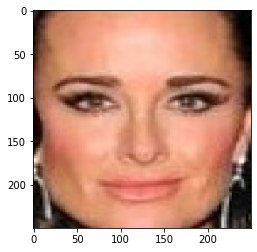

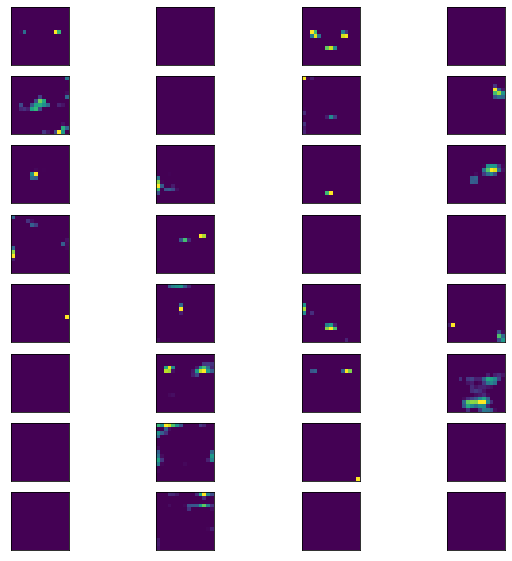

In [233]:
# plot feature map of first conv layer for given image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
from tensorflow.keras.models import Model


# redefine model to output right after input layer
model_fm = Model(inputs=base_model_vgg_tune.inputs, outputs=base_model_vgg_tune.layers[17].output)  # change here

# load the image with the required shape
img = load_img('Data/Training/female/202598.jpg.jpg', target_size=(250, 250, 3))
plt.imshow(img)
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image
img = preprocess_input(img)
# plt.show()
# get feature map for first hidden layer
feature_maps = model_fm.predict(img)
print(feature_maps.shape)
# plot all 64 maps in an 8x4 matrix
height = 8
width = 4
ix = 1

plt.figure(figsize=(10, 10))
for _ in range(height):
    for _ in range(width):
        # specify subplot and turn of axis
        ax = plt.subplot(height, width, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1])
        ix += 1
# show the figure
plt.show()

(1, 250, 250, 64)


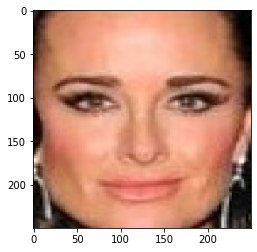

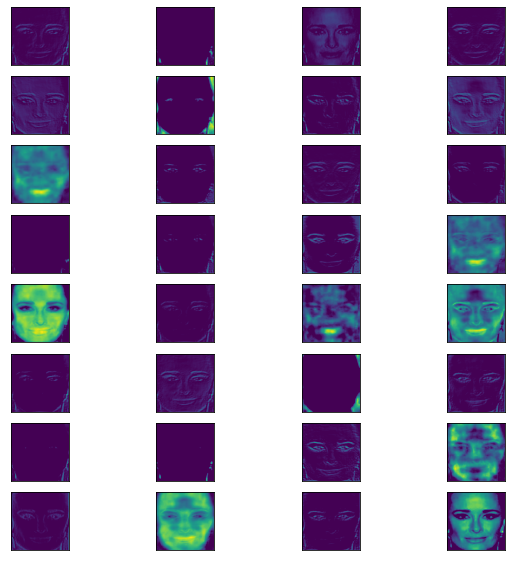

In [241]:
# plot feature map of first conv layer for given image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
from tensorflow.keras.models import Model


# redefine model to output right after input layer
model_fm = Model(inputs=base_model_vgg_tune.inputs, outputs=base_model_vgg_tune.layers[1].output)  # change here

# load the image with the required shape
img = load_img('Data/Training/female/202598.jpg.jpg', target_size=(250, 250, 3))
plt.imshow(img)
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image
img = preprocess_input(img)
# plt.show()
# get feature map for first hidden layer
feature_maps = model_fm.predict(img)
print(feature_maps.shape)
# plot all 32 maps in an 8x4 matrix
height = 8
width = 4
ix = 1

plt.figure(figsize=(10, 10))
for _ in range(height):
    for _ in range(width):
        # specify subplot and turn of axis
        ax = plt.subplot(height, width, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1])
        ix += 1
# show the figure
plt.show()


In [246]:
base_model_vgg_tune.layers[17].output

<KerasTensor: shape=(None, 15, 15, 512) dtype=float32 (created by layer 'block5_conv3')>